In [33]:
import sklearn as sk
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def calculate_goal_dif(home_or_away, home_score, away_score):
    if home_or_away == 'HOME':
        return home_score - away_score
    else:
        return away_score - home_score
    

def normalize_data(df):
    norm_df = df.copy()
    for col in norm_df.columns:
        if norm_df.dtypes[col] == 'object':
            continue
        col_min = norm_df[col].min()
        col_max = norm_df[col].max()
        norm_df[col] = (norm_df[col] - col_min) / (col_max - col_min)
    return norm_df

In [15]:
file_path = '/Users/tylerviducic/dev/hockey_analytics/gamescore_model/data/cleaned_data/'
files = glob.glob(file_path + '*.csv')
df = pd.concat([pd.read_csv(f) for f in files], ignore_index = True)
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [16]:
df['game_goal_differential'] = df.apply(lambda row: calculate_goal_dif(row['home_or_away'], row['home_score'], row['away_score']), axis = 1)

In [17]:
norm_df = normalize_data(df)

In [18]:
norm_df = norm_df.sample(frac = 1).reset_index(drop = True)

In [19]:
longest = 0
for column in norm_df.columns:
    if len(column) > longest:
        longest = len(column)

for i, column in enumerate(norm_df.columns):
    end = ' ' * (longest - len(column)) + ' | '
    if (i+1) % 2 == 0:
        end = '\n'
    print(column, end = end)

playerId                                                | season
name                                                    | gameId
playerTeam                                              | opposingTeam
home_or_away                                            | gameDate
position                                                | icetime
shifts                                                  | gameScore
iceTimeRank                                             | I_F_xOnGoal
I_F_xGoals                                              | I_F_xRebounds
I_F_xFreeze                                             | I_F_xPlayStopped
I_F_xPlayContinuedInZone                                | I_F_xPlayContinuedOutsideZone
I_F_flurryAdjustedxGoals                                | I_F_scoreVenueAdjustedxGoals
I_F_flurryScoreVenueAdjustedxGoals                      | I_F_primaryAssists
I_F_secondaryAssists                                    | I_F_shotsOnGoal
I_F_missedShots                                        

In [20]:
features = ['iceTimeRank', 'I_F_primaryAssists', 'I_F_secondaryAssists', 'I_F_goals', 'I_F_hits', 'I_F_takeaways', 
            'I_F_dZoneGiveaways', 'shotsBlockedByPlayer','faceoffsWon', 'faceoffsLost', 'penalties', 
            'penaltiesDrawn', 'OnIce_F_xGoals', 'OnIce_F_goals', 'OnIce_A_xGoals', 'OnIce_A_goals']
target = ['game_goal_differential']


In [21]:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(norm_df[features], norm_df[target], test_size = 0.2)


In [22]:
from sklearn import linear_model

model = linear_model.LinearRegression()

In [23]:
model.fit(x_train, y_train)

LinearRegression()

In [24]:
[print(len(model.coef_[0]))]
print(f'coeficcients: ')
for feature, coef in zip(features, model.coef_[0]):
    print(f'{feature}: {coef}')

16
coeficcients: 
iceTimeRank: 0.021249718258586372
I_F_primaryAssists: 0.1110637533347133
I_F_secondaryAssists: 0.09438991917660598
I_F_goals: 0.11559253358442156
I_F_hits: -0.0241110040259205
I_F_takeaways: 0.02855679449002634
I_F_dZoneGiveaways: 0.022427568905796356
shotsBlockedByPlayer: 0.09076443338832689
faceoffsWon: 0.012037170758861931
faceoffsLost: -0.02519521591939622
penalties: -0.010044307356709579
penaltiesDrawn: 0.0010035867319858308
OnIce_F_xGoals: -0.02737929426804343
OnIce_F_goals: 0.25883112326005486
OnIce_A_xGoals: 0.02071786489734559
OnIce_A_goals: -0.2950005709601649


In [25]:
pred_y = model.predict(x_test)

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

print(f'MSE: {mean_squared_error(y_test, pred_y)}')
print(f'R2: {r2_score(y_test, pred_y)}')

MSE: 0.010956044595608914
R2: 0.19419275856319795


In [38]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, 
    norm_df[features],
    norm_df[target],
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True
)

coefs = pd.DataFrame(
    [model.coef_[0] for model in cv_model['estimator']], columns=features
)

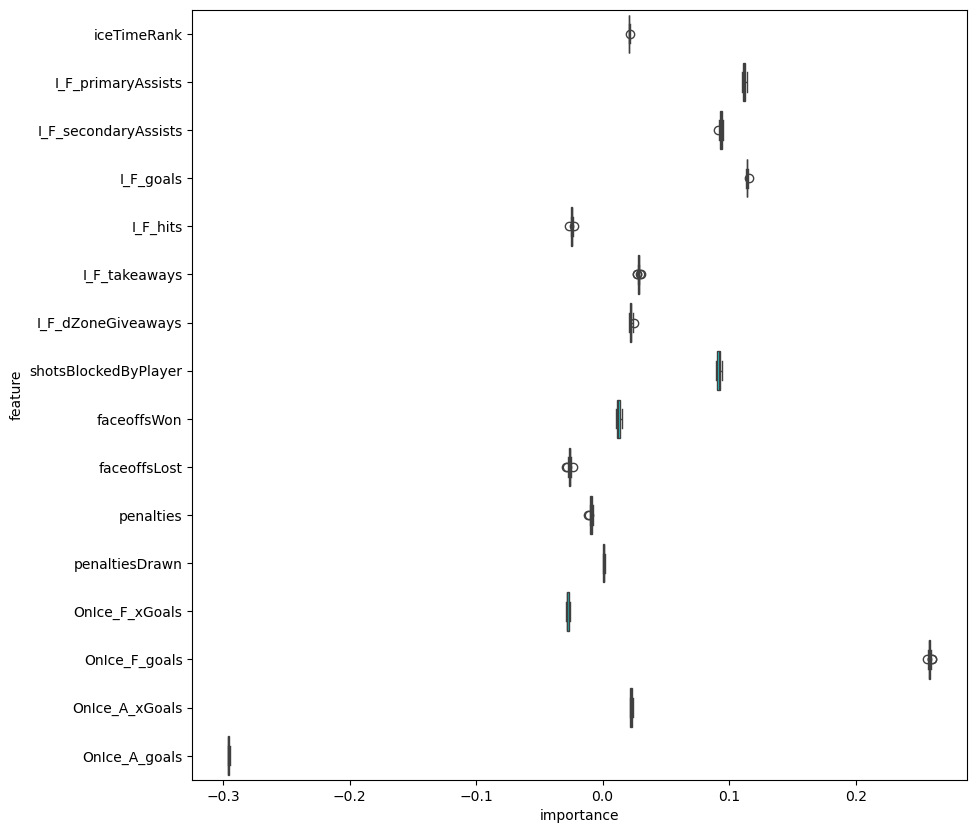

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=coefs, orient="h", ax=ax, color='cyan')
ax.set_xlabel('importance')
ax.set_ylabel('feature')
plt.show()